# 1D DenseNet CNN
Similar to the architecture in this paper: https://arxiv.org/abs/1608.06993
Adapted to a truncated, 1D version for our purposes. 

In [13]:
# imports
from keras.layers import Conv2D, BatchNormalization, Dense, Dropout, Activation, AveragePooling1D, GaussianNoise
from keras.layers import Input, Concatenate, Flatten, Conv1D, MaxPooling1D, Reshape, SeparableConv1D
from keras.layers import GlobalMaxPooling1D, Lambda, GlobalAveragePooling1D
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras import backend as K
import numpy as np
import os

In [ ]:
K.clear_session()
del model

In [3]:
# our data
start_target_size = (672, 4)
batch_size = 16
x_train = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/x_train.npy')
y_train = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/y_train.npy')


In [6]:
# 1D Densenet

#set of conv blocks wrapper
def conv_block(x, dim):
    x1 = Conv1D(dim, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x1 = BatchNormalization()(x1)
    x1 = Conv1D(dim, kernel_size=3, strides=1, padding='same', activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    return x1

# dense block wrapper
def dense_block(inlayer, convs, dims):
    conv_list = []
    ministem = conv_block(inlayer, dims)
    ministem = BatchNormalization()(ministem)
    conv_list.append(ministem)
    ministem = conv_block(conv_list[0], dims)
    ministem = BatchNormalization()(ministem)
    conv_list.append(ministem)
    for _ in range(convs-2):
        x = Concatenate()([layer for layer in conv_list])
        x = conv_block(x, dims)
        x = BatchNormalization()(x)
        conv_list.append(x)
    return conv_list[-1]

## build our model
# stem
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x = Conv1D(512, kernel_size=7, strides=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)
    
# dense block 1
d1 = dense_block(x, 6, 64)

#transition
t = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d1)
t = MaxPooling1D(pool_size=2, strides=2)(t)

# dense block 2
d2 = dense_block(t, 12, 64)

# optional depth, doesn't seem to help
'''
#transition
t2 = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d2)
t2 = AveragePooling1D(pool_size=2, strides=2)(t2)

# dense block 2
d3 = dense_block(t2, 6, 64)
'''

# exit stem
fc = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d2)
fc = Flatten()(fc)
fc = Dense(1024, activation='relu')(fc)
fc = Dropout(0.5)(fc)
predictions = Dense(1, activation='sigmoid')(fc)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])
model.summary()

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 672, 4)       0                                            
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 672, 4)       0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 336, 512)     14848       gaussian_noise_3[0][0]           
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 167, 512)     0           conv1d_39[0][0]                  
__________________________________________________________________________________________________
conv1d_40 


Epoch 00001: val_loss improved from inf to 0.60291, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights\weights-01-0.60.hdf5
 - 103s - loss: 0.6707 - binary_accuracy: 0.6052 - val_loss: 0.6029 - val_binary_accuracy: 0.6419
Epoch 2/30

Epoch 00002: val_loss improved from 0.60291 to 0.56998, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights\weights-02-0.57.hdf5
 - 74s - loss: 0.5980 - binary_accuracy: 0.6691 - val_loss: 0.5700 - val_binary_accuracy: 0.7006
Epoch 3/30

Epoch 00003: val_loss improved from 0.56998 to 0.56154, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights\weights-03-0.56.hdf5
 - 73s - loss: 0.5779 - binary_accuracy: 0.6883 - val_loss: 0.5615 - val_binary_accuracy: 0.7054
Epoch 4/30

Epoch 00004: val_loss improved from 0.56154 to 0.55106, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights\weights-04-0.55.hdf5
 - 73s - loss: 0.56

In [8]:
# 1D Densenet, with separable depthwise 1D convs

#set of conv blocks wrapper
def conv_block(x, dim):
    x1 = SeparableConv1D(dim, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x1 = BatchNormalization()(x1)
    x1 = SeparableConv1D(dim, kernel_size=3, strides=1, padding='same', activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    return x1

# dense block wrapper
def dense_block(inlayer, convs, dims):
    conv_list = []
    ministem = conv_block(inlayer, dims)
    ministem = BatchNormalization()(ministem)
    conv_list.append(ministem)
    ministem = conv_block(conv_list[0], dims)
    ministem = BatchNormalization()(ministem)
    conv_list.append(ministem)
    for _ in range(convs-2):
        x = Concatenate()([layer for layer in conv_list])
        x = conv_block(x, dims)
        x = BatchNormalization()(x)
        conv_list.append(x)
    return conv_list[-1]

## build our model
# stem
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x = Conv1D(512, kernel_size=7, strides=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)
    
# dense block 1
d1 = dense_block(x, 6, 64)

#transition
t = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d1)
t = MaxPooling1D(pool_size=2, strides=2)(t)

# dense block 2
d2 = dense_block(t, 12, 64)

# optional depth
'''
#transition
t2 = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d2)
t2 = AveragePooling1D(pool_size=2, strides=2)(t2)

# dense block 2
d3 = dense_block(t2, 6, 64)
'''

# exit stem
fc = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d2)
#fc = GlobalAveragePooling1D()(fc)
fc = Flatten()(fc)
fc = Dense(1024, activation='relu')(fc)
fc = Dropout(0.5)(fc)
predictions = Dense(1, activation='sigmoid')(fc)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])
model.summary()

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/1DdenseNet/separable_CNN_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 672, 4)       0                                            
__________________________________________________________________________________________________
gaussian_noise_5 (GaussianNoise (None, 672, 4)       0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_81 (Conv1D)              (None, 336, 512)     14848       gaussian_noise_5[0][0]           
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 167, 512)     0           conv1d_81[0][0]                  
__________________________________________________________________________________________________
separable_


Epoch 00001: val_loss improved from inf to 0.63842, saving model to D:/Projects/Github/SyntheticPromoter/1DdenseNet/separable_CNN_weights\weights-01-0.64.hdf5
 - 134s - loss: 0.7047 - binary_accuracy: 0.5651 - val_loss: 0.6384 - val_binary_accuracy: 0.6187
Epoch 2/30

Epoch 00002: val_loss improved from 0.63842 to 0.57821, saving model to D:/Projects/Github/SyntheticPromoter/1DdenseNet/separable_CNN_weights\weights-02-0.58.hdf5
 - 83s - loss: 0.6164 - binary_accuracy: 0.6566 - val_loss: 0.5782 - val_binary_accuracy: 0.6834
Epoch 3/30

Epoch 00003: val_loss improved from 0.57821 to 0.57262, saving model to D:/Projects/Github/SyntheticPromoter/1DdenseNet/separable_CNN_weights\weights-03-0.57.hdf5
 - 83s - loss: 0.5940 - binary_accuracy: 0.6791 - val_loss: 0.5726 - val_binary_accuracy: 0.6920
Epoch 4/30

Epoch 00004: val_loss improved from 0.57262 to 0.56834, saving model to D:/Projects/Github/SyntheticPromoter/1DdenseNet/separable_CNN_weights\weights-04-0.57.hdf5
 - 83s - loss: 0.5809 -

In [10]:
# 1D Densenet with elongated beginning stem

#set of conv blocks wrapper
def conv_block(x, dim):
    x1 = Conv1D(dim, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x1 = BatchNormalization()(x1)
    x1 = Conv1D(dim, kernel_size=3, strides=1, padding='same', activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    return x1

# dense block wrapper
def dense_block(inlayer, convs, dims):
    conv_list = []
    ministem = conv_block(inlayer, dims)
    ministem = BatchNormalization()(ministem)
    conv_list.append(ministem)
    ministem = conv_block(conv_list[0], dims)
    ministem = BatchNormalization()(ministem)
    conv_list.append(ministem)
    for _ in range(convs-2):
        x = Concatenate()([layer for layer in conv_list])
        x = conv_block(x, dims)
        x = BatchNormalization()(x)
        conv_list.append(x)
    return conv_list[-1]

## build our model
# stem
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
#x = Conv1D(512, kernel_size=7, strides=2, padding='same', activation='relu')(x)
    
# dense block 1
d1 = dense_block(x, 6, 128)

#transition
t = Conv1D(128, kernel_size=1, strides=1, padding='same', activation='relu')(d1)
t = MaxPooling1D(pool_size=2, strides=2)(t)

# dense block 2
d2 = dense_block(t, 12, 64)

# optional depth
'''
#transition
t2 = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d2)
t2 = AveragePooling1D(pool_size=2, strides=2)(t2)

# dense block 2
d3 = dense_block(t2, 6, 64)
'''

# exit stem
fc = Conv1D(64, kernel_size=1, strides=1, padding='same', activation='relu')(d2)
fc = MaxPooling1D(pool_size=2, strides=2)(fc)
fc = Flatten()(fc)
fc = Dense(1024, activation='relu')(fc)
fc = Dropout(0.5)(fc)
predictions = Dense(1, activation='sigmoid')(fc)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])
model.summary()

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/1DdenseNet/longstem_CNN_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 672, 4)       0                                            
__________________________________________________________________________________________________
gaussian_noise_7 (GaussianNoise (None, 672, 4)       0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_122 (Conv1D)             (None, 672, 128)     640         gaussian_noise_7[0][0]           
__________________________________________________________________________________________________
batch_normalization_267 (BatchN (None, 672, 128)     512         conv1d_122[0][0]                 
__________________________________________________________________________________________________
conv1d_123

__________________________________________________________________________________________________
conv1d_137 (Conv1D)             (None, 336, 64)      4160        batch_normalization_287[0][0]    
__________________________________________________________________________________________________
batch_normalization_288 (BatchN (None, 336, 64)      256         conv1d_137[0][0]                 
__________________________________________________________________________________________________
conv1d_138 (Conv1D)             (None, 336, 64)      12352       batch_normalization_288[0][0]    
__________________________________________________________________________________________________
batch_normalization_289 (BatchN (None, 336, 64)      256         conv1d_138[0][0]                 
__________________________________________________________________________________________________
batch_normalization_290 (BatchN (None, 336, 64)      256         batch_normalization_289[0][0]    
__________


Epoch 00001: val_loss improved from inf to 0.59764, saving model to D:/Projects/Github/SyntheticPromoter/1DdenseNet/longstem_CNN_weights\weights-01-0.60.hdf5
 - 207s - loss: 0.6841 - binary_accuracy: 0.6059 - val_loss: 0.5976 - val_binary_accuracy: 0.6731
Epoch 2/30

Epoch 00002: val_loss improved from 0.59764 to 0.58804, saving model to D:/Projects/Github/SyntheticPromoter/1DdenseNet/longstem_CNN_weights\weights-02-0.59.hdf5
 - 144s - loss: 0.5866 - binary_accuracy: 0.6856 - val_loss: 0.5880 - val_binary_accuracy: 0.6974
Epoch 3/30

Epoch 00003: val_loss did not improve
 - 144s - loss: 0.5672 - binary_accuracy: 0.6981 - val_loss: 0.5929 - val_binary_accuracy: 0.7151
Epoch 4/30

Epoch 00004: val_loss improved from 0.58804 to 0.57400, saving model to D:/Projects/Github/SyntheticPromoter/1DdenseNet/longstem_CNN_weights\weights-04-0.57.hdf5
 - 144s - loss: 0.5575 - binary_accuracy: 0.7064 - val_loss: 0.5740 - val_binary_accuracy: 0.7071
Epoch 5/30

Epoch 00005: val_loss improved from 0.5

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [17]:
x_test = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/x_test.npy')
y_test = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/y_test.npy')

model_list = ['D:/Projects/Github/SyntheticPromoter/1DdenseNet/vanilla_CNN_weights/weights-29-0.52.hdf5',
              'D:/Projects/Github/SyntheticPromoter/1DdenseNet/separable_CNN_weights/weights-25-0.52.hdf5',
              'D:/Projects/Github/SyntheticPromoter/1DdenseNet/longstem_CNN_weights/weights-22-0.53.hdf5',
             ]
roc_list = []
for path in model_list:
    model = load_model(path)
    y_pred = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_list.append([fpr, tpr, auc])

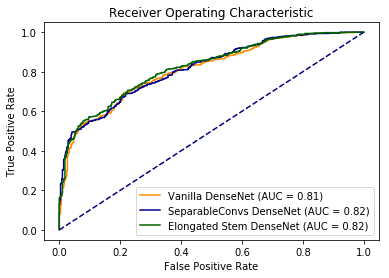

In [19]:
#plot roc curve
plt.plot(roc_list[0][0], roc_list[0][1], color='darkorange', label='Vanilla DenseNet (AUC = %0.2f)' % roc_list[0][2])
plt.plot(roc_list[1][0], roc_list[1][1], color='darkblue', label='SeparableConvs DenseNet (AUC = %0.2f)' % roc_list[1][2])
plt.plot(roc_list[2][0], roc_list[2][1], color='darkgreen', label='Elongated Stem DenseNet (AUC = %0.2f)' % roc_list[2][2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('c:/users/wolf/desktop/SynPro/roc.png')
plt.show()